# Modelling and Experimentation

This notebook aims to show how the Modelling and Experimentation step can be performed. 

The idea is to try different algorithms with different hyperparameters to model our dataset, taking the one that produces best results in terms of the metric we are checking, as the model to be applied in our e2e pipeline.

## 1. Import needed libraries

In [2]:
import torch
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import plotly.express as px

import warnings
warnings.filterwarnings("ignore")

In [3]:
torch.cuda.is_available()

False

## 2. Load shipments data

In [6]:
# df = pd.read_csv('../../data/01_raw/shipments.csv')
df = pd.read_parquet('model_input.pq')
df['time_var'] = pd.to_datetime(df['time_var']) # Change to timestamp
# df['item'] = df['prod_code'] + '#' + df['customer'] + '#' + df['location'] 
# df.sort_values(['item', 'time_var'], inplace=True)
df.head()

,time_var,new_shipments,model_id,customer_encoded,location_encoded,category_encoded,year_2021,year_2022,year_2023,sin_month,...,GoodFriday,LabourDay,AssumptionDay,FiestaNacionalEspana,AllSaintsDay,ConstitutionDay,ImmaculateConception,ChristmasDay,number_of_holidays,is_holiday
0,2020-10-19 00:00:00+00:00,339919.0,1424_01#LIDL#BILBAO,3,0,2,False,False,False,-0.866025,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2020-10-26 00:00:00+00:00,432396.0,1424_01#LIDL#BILBAO,3,0,2,False,False,False,-0.866025,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
2,2020-11-02 00:00:00+00:00,361797.0,1424_01#LIDL#BILBAO,3,0,2,False,False,False,-0.500000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2020-11-09 00:00:00+00:00,369954.0,1424_01#LIDL#BILBAO,3,0,2,False,False,False,-0.500000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2020-11-16 00:00:00+00:00,413049.0,1424_01#LIDL#BILBAO,3,0,2,False,False,False,-0.500000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
df['model_id'].unique()

array(['1424_01#LIDL#BILBAO', '1466_03#BM#SANSEBASTIAN',
       '1522_03#EROSKI#VITORIA', '2093_01#MERCADONA#BILBAO',
       '2241_05#LIDL#SANSEBASTIAN', '2441_04#LIDL#SANSEBASTIAN',
       '2493_07#ALDI#VITORIA', '2496_04#LIDL#VITORIA',
       '3186_03#LIDL#SANSEBASTIAN', '3590_01#EROSKI#VITORIA',
       '3677_04#ALDI#VITORIA', '3735_01#LIDL#VITORIA',
       '3954_08#BM#BILBAO', '4266_08#EROSKI#BILBAO',
       '4417_02#ALDI#SANSEBASTIAN', '4758_08#MERCADONA#VITORIA',
       '4888_03#BM#BILBAO', '5069_01#MERCADONA#SANSEBASTIAN',
       '5693_05#LIDL#SANSEBASTIAN', '5845_07#ALDI#BILBAO',
       '5848_02#EROSKI#VITORIA', '6009_01#LIDL#VITORIA',
       '6213_03#LIDL#VITORIA', '6250_05#EROSKI#BILBAO',
       '6258_07#ALDI#BILBAO', '6860_07#MERCADONA#VITORIA',
       '7196_04#ALDI#VITORIA', '7638_05#LIDL#SANSEBASTIAN',
       '7694_02#EROSKI#VITORIA', '8075_05#EROSKI#VITORIA',
       '8526_03#LIDL#BILBAO', '8684_05#LIDL#SANSEBASTIAN',
       '8814_04#MERCADONA#SANSEBASTIAN', '9340_08#LIDL#S

### Variables

In [14]:
time_var = 'time_var'
target_var = 'new_shipments'
model_id = 'model_id'
model_id_test = '6860_07#MERCADONA#VITORIA'
y_hat = 'y_hat'
horizon = 20
fcst_start_date = pd.to_datetime(df[df[model_id]==model_id_test][time_var].values[-horizon])
print(fcst_start_date)

2023-05-29 00:00:00


### Visual inspection of the data

<Axes: xlabel='time_var'>

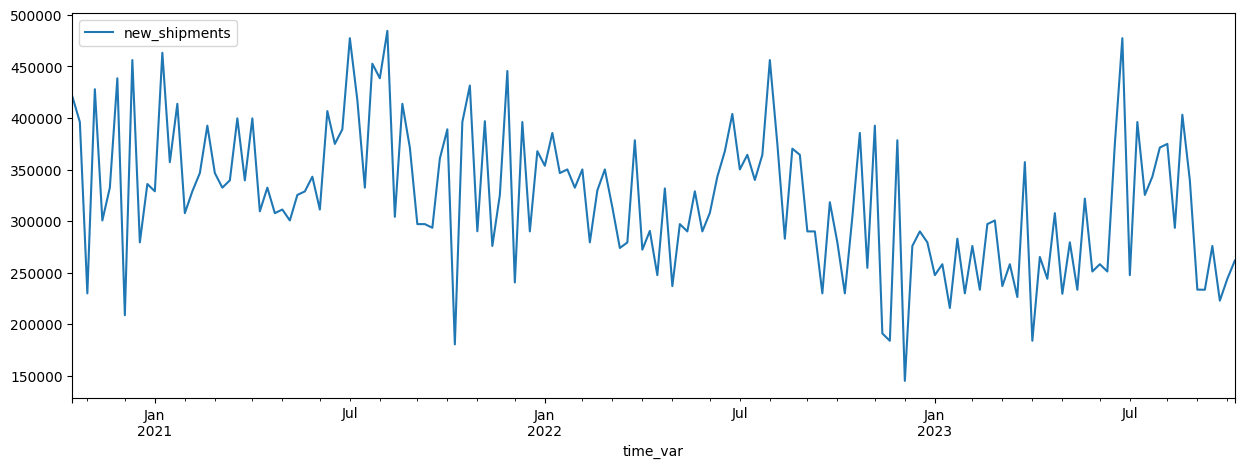

In [6]:
fig, ax = plt.subplots(figsize=(15, 5))
df[df[model_id]==model_id_test].set_index(time_var)[[target_var]].plot(ax=ax)

# fig = px.line(df, x="time_var", y='shipments', hover_data={"time_var": "|%B %d, %Y"})
# fig.update_xaxes(dtick="M1", tickformat="%b\n%Y")
# fig.show()

## 3. Metrics definition

In [ ]:
def compute_accuracy(df, y='shipments', y_pred='y_hat'):    
    # Initialize the accuracy metric to 0
    metric = 0

    # Check if the sum of actual values is not equal to 0    
    if df[y].sum() != 0:
        # Calculate the accuracy using the formula:
        # 1 - (sum of absolute differences between actual and predicted) / sum of actual values
        metric = np.max([0, 1 - np.abs(df[y_pred] - df[y]).sum() / df[y].sum()])
    # If the sum of actual values is 0 and the sum of absolute differences is 0, set the accuracy to 1
    elif (df[y].sum() == 0) & (np.abs(df[y_pred] - df[y]).sum() == 0):
        metric = 1
    # If the sum of actual values is 0 and the sum of absolute differences is greater than 0, set the accuracy to 0
    elif (df[y].sum() == 0) & (np.abs(df[y_pred] - df[y]).sum() > 0):
        metric = 0

    # Return the calculated accuracy metric as a pandas Series
    return pd.Series({'accuracy': metric})

## 4.1 Time-series model: ARIMA

The Time Series model can be used as a local model, applied on every DFU or item we have in the dataset separately, and not considering the input features or drivers generated in previous steps.

In [7]:
import statsmodels.api as sm

# parameters
order=(1, 1, 1)
seasonal_order=(1,1,1,2)
trend='c'

def ts_fit_predict(df, horizon, order, seasonal_order, trend):
    print(f"Processing {df[model_id].iloc[0]}")
    df = df.sort_values(time_var).reset_index()
    endog = df[target_var][:-horizon]
    # Construct the model
    # mod = sm.tsa.SARIMAX(endog, order=(1, 1, 1), trend='c')
    mod = sm.tsa.SARIMAX(endog, order=order, seasonal_order=seasonal_order, trend=trend)
    # Estimate the parameters
    res = mod.fit(disp=0)
    #print(res.summary())
    fcast = res.get_forecast(steps=horizon).summary_frame()    
    df[y_hat] , df['y_ci_lower'], df['y_ci_upper'] = np.nan, np.nan, np.nan    
    df.loc[-horizon:,y_hat], df.loc[-horizon:,'y_ci_lower'], df.loc[-horizon:,'y_ci_upper'] = fcast['mean'], fcast['mean_ci_lower'], fcast['mean_ci_upper']
    # Note: since we did not specify the alpha parameter, the
    # confidence level is at the default, 95%
    #print(fcast_res.summary_frame())
    return df

df_res_ts = df.groupby(model_id).apply(lambda x: ts_fit_predict(df=x, horizon=horizon, order=order, seasonal_order=seasonal_order, trend=trend)).reset_index(drop=True)

1424_01#LIDL#BILBAO
1466_03#BM#SANSEBASTIAN
1522_03#EROSKI#VITORIA
2093_01#MERCADONA#BILBAO
2241_05#LIDL#SANSEBASTIAN
2441_04#LIDL#SANSEBASTIAN
2493_07#ALDI#VITORIA
2496_04#LIDL#VITORIA
3186_03#LIDL#SANSEBASTIAN
3590_01#EROSKI#VITORIA
3677_04#ALDI#VITORIA
3735_01#LIDL#VITORIA
3954_08#BM#BILBAO
4266_08#EROSKI#BILBAO
4417_02#ALDI#SANSEBASTIAN
4758_08#MERCADONA#VITORIA
4888_03#BM#BILBAO
5069_01#MERCADONA#SANSEBASTIAN
5693_05#LIDL#SANSEBASTIAN
5845_07#ALDI#BILBAO
5848_02#EROSKI#VITORIA
6009_01#LIDL#VITORIA
6213_03#LIDL#VITORIA
6250_05#EROSKI#BILBAO
6258_07#ALDI#BILBAO
6860_07#MERCADONA#VITORIA
7196_04#ALDI#VITORIA
7638_05#LIDL#SANSEBASTIAN
7694_02#EROSKI#VITORIA
8075_05#EROSKI#VITORIA
8526_03#LIDL#BILBAO
8684_05#LIDL#SANSEBASTIAN
8814_04#MERCADONA#SANSEBASTIAN
9340_08#LIDL#SANSEBASTIAN
9876_02#BM#BILBAO


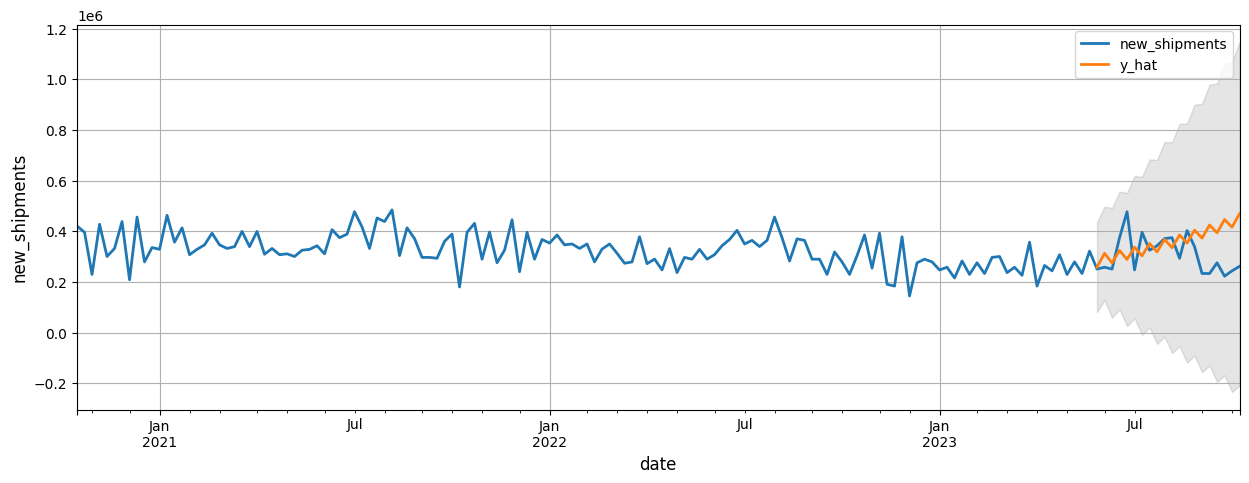

In [8]:
fig, ax = plt.subplots(figsize=(15, 5))

# Plot the data (here we are subsetting it to get a better look at the forecasts)
plot_df = df_res[df_res[model_id]==model_id_test]
plot_df = plot_df.set_index(time_var)
plot_df[[target_var, y_hat]].plot(ax=ax, linewidth=2)
ax.fill_between(plot_df.index[-horizon:], plot_df['y_ci_lower'][-horizon:], plot_df['y_ci_upper'][-horizon:], color='k', alpha=0.1)
ax.set_ylabel(target_var, fontsize=12)
ax.set_xlabel('date', fontsize=12)
ax.legend(prop={'size': 10})
ax.grid()

In [ ]:
df_res_ts.dropna().groupby('item').apply(compute_accuracy, y='shipments', y_pred='y_hat')

In [ ]:
df_res.dropna().groupby('category').apply(compute_accuracy, y='shipments', y_pred='y_hat')

## 4.2. Machine Learning model: LightGBM

The Machine Learning model can be used as a global model, fitting it to the whole dataset and using as inputs the features or drivers generated in previous steps.

In [29]:
import lightgbm as lgb


# defining parameters 
params = {'task': 'train', 
          'boosting': 'gbdt',
          'objective': 'regression',
          'num_leaves': 10,
          'learnnig_rage': 0.05,
          'metric': {'l2','l1'},
          'verbose': -1}


def ml_predict_item(df, model):
    print(f"Processing {df[model_id].iloc[0]}")
    # test data
    df_test = df[df[time_var].values>=fcst_start_date].drop(columns=[time_var, target_var, model_id]).drop(['year_2021', 'category', 'promo_type', 'promo_type_aggregated'], axis=1).astype(float)
    y_test = df[df[time_var].values>=fcst_start_date][target_var]
    dataset_test = lgb.Dataset(df_test, y_test)
    # prediction
    y_pred = model.predict(df_test)
    df[y_hat] = np.nan
    df.loc[df[time_var].values>=fcst_start_date, y_hat] = y_pred
    return df


def ml_fit_predict(df, horizon, params):    
    # training data
    df_train = df[df[time_var].values<fcst_start_date].drop(columns=[time_var, target_var, model_id]).drop(['year_2021', 'category', 'promo_type', 'promo_type_aggregated'], axis=1).astype(float)
    y_train = df[df[time_var].values<fcst_start_date][target_var]
    dataset_train = lgb.Dataset(df_train, y_train)
    # fitting the model globally
    lgbm_model = lgb.train(params, train_set=dataset_train)
    # make predictions locally
    df = df.groupby(model_id).apply(lambda x: ml_fit_predict(df=df, model=lgbm_model)).reset_index(drop=True)    
    return df

df_res_ml = ml_fit_predict(dataset=df, horizon=horizon, params=params)

## 5. Conclusions and further work